# Loan Default Risk

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import load_model
from xgboost import XGBClassifier
from xgboost import plot_importance

Using TensorFlow backend.


In [2]:
def plot_var(col_name, title, continuous, dataset, x1limit=False, x2limit=False, x1l=0, x1u=0, x2l=0, x2u=0):
    """
    Plot a variable against the response variable loan status
    - col_name is the variable name in the dataframe
    - title is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    - dataset is the pandas dataframe containing the dataset
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)

    # Plot without loan status
    if continuous:
        sns.distplot(dataset.loc[dataset[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(dataset[col_name], order=sorted(dataset[col_name].unique()),
                      color='#4f81bd', saturation=1, ax=ax1)
    if x1limit:
        ax1.set_xlim([x1l, x1u])
    ax1.set_xlabel(title)
    ax1.set_ylabel('Frequency')
    ax1.set_title(title)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=dataset, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(title + ' by Loan Status')
    else:
        charge_off_rates = dataset.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:, 'Default']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#4f81bd', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Default')
        ax2.set_title('Default Rate by ' + title)
    if x2limit:
        ax2.set_xlim([x2l, x2u])
    ax2.set_xlabel(title)

    plt.tight_layout()

# Preliminary Data Analysis

In [3]:
# read in the entire raw dataset
dataset = pd.read_csv(Path('../data/2017Half_clean.csv'), header=0)
pd.set_option('display.max_columns', None)
dataset.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,application_type,mort_acc,pub_rec_bankruptcies
0,5000,36 months,7.35%,155.19,A,5 years,MORTGAGE,60000.0,Not Verified,Fully Paid,car,15.76,0,Oct-04,12,0,3697,13.20%,25,w,5385.245133,Individual,1,0
1,7500,36 months,7.35%,232.79,A,7 years,MORTGAGE,110000.0,Not Verified,Fully Paid,debt_consolidation,13.12,0,Mar-13,19,0,23348,27.20%,27,w,7642.289180,Individual,4,0
2,9600,36 months,7.97%,300.70,A,< 1 year,OWN,140000.0,Not Verified,Fully Paid,credit_card,18.34,0,Aug-05,16,0,11808,48.60%,44,w,10283.629660,Individual,3,0
3,2000,36 months,7.07%,61.82,A,2 years,RENT,80000.0,Not Verified,Fully Paid,medical,12.15,0,Apr-05,9,0,38,0.30%,12,w,2097.014574,Individual,0,0
4,7200,36 months,24.85%,285.70,E,2 years,RENT,50000.0,Source Verified,Fully Paid,debt_consolidation,6.07,0,Jan-00,4,0,3560,98.90%,5,w,7206.461000,Individual,0,0


In [4]:
# Look at how many of each response variable we have
print(dataset['loan_status'].value_counts(dropna=False))
print(dataset['loan_status'].value_counts(normalize=True, dropna=False))
print(dataset.shape)

Fully Paid    29145
Default       18494
Name: loan_status, dtype: int64
Fully Paid    0.611789
Default       0.388211
Name: loan_status, dtype: float64
(47639, 24)


| Status     | Count | Percentage |
| -----------|:-----:|:----------:|
| Fully Paid | 29145 | 61% |
| Charged Off | 18494 | 39% |

47639 rows x 23 Columns

A list of percentage of missing values in a column

In [5]:
missing_values = ((dataset.isna().sum()) / len(dataset.index)).sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values*100)

emp_length    7.225173
revol_util    0.065073
dti           0.056676
dtype: float64


| Variable | % Missing |
| ---------|:----:|
| emp_length | 7.225173% |
| revol_util | 0.065073% |
| dti | 0.056676% |

In [6]:
# Look at the data type of each column
print(dataset.dtypes)

loan_amnt                 int64
term                     object
int_rate                 object
installment             float64
grade                    object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
purpose                  object
dti                     float64
delinq_2yrs               int64
earliest_cr_line         object
open_acc                  int64
pub_rec                   int64
revol_bal                 int64
revol_util               object
total_acc                 int64
initial_list_status      object
total_pymnt             float64
application_type         object
mort_acc                  int64
pub_rec_bankruptcies      int64
dtype: object


| Variable | Type |
| ---------|:----:|
| Loan Amount | Numerical |
| Term | Categorical |
| Interest Rate | Numerical |
| Installment | Numerical |
| Grade | Categorical |
| Employment Length | Categorical |
| Home Ownership | Categorical |
| Annual Income | Numerical |
| Verification Status | Categorical |
| Loan Status| Categorical |
| Purpose | Categorical |
| Debt-to-Income Ratio | Numerical |
| Delinquency | Categorical |
| Earliest Credit Line | Numerical |
| Open Accounts | Numerical |
| Public Records | Categorical |
| Revolving Balance | Numerical |
| Revolving Utility | Numerical |
| Total Account | Numerical |
| Initial List Status | Categorical |
| Application Type | Categorical |
| Mortage Account | Numerical |
| Public Record of Bankruptcies | Categorical |

# Exploratory Data Analysis

### Annual Income (Numerical)
The self-reported annual income provided by the borrower during registration

               count          mean           std  min      25%      50%  \
loan_status                                                               
Default      18494.0  74073.439857  46806.677767  0.0  45000.0  64000.0   
Fully Paid   29145.0  80899.315013  69096.968024  0.0  49000.0  69000.0   

                 75%        max  
loan_status                      
Default      90000.0   982000.0  
Fully Paid   97133.0  5616890.0  
               count       mean       std  min        25%        50%  \
loan_status                                                            
Default      18494.0  11.058230  0.590522  0.0  10.714440  11.066654   
Fully Paid   29145.0  11.129532  0.625351  0.0  10.799596  11.141876   

                   75%        max  
loan_status                        
Default      11.407576  13.797348  
Fully Paid   11.483847  15.541289  


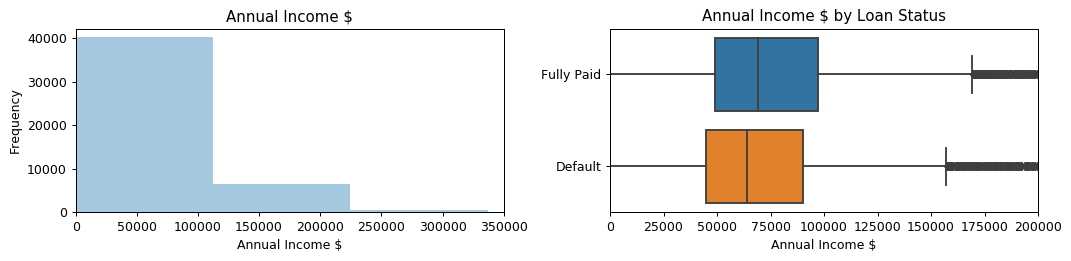

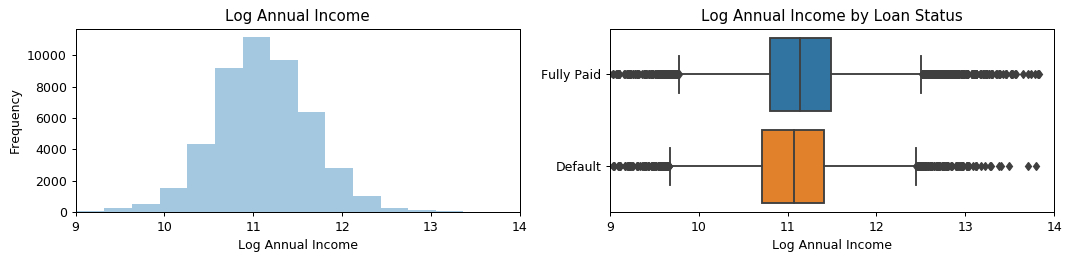

In [7]:
print(dataset.groupby('loan_status')['annual_inc'].describe())
plot_var('annual_inc', 'Annual Income $', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=-1, x1u=350000, x2l=-1, x2u=200000)
# Because the plot is right skewed we take a log transform of the annual income
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log(x + 1))
dataset.drop('annual_inc', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_annual_inc'].describe())
plot_var('log_annual_inc', 'Log Annual Income', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=9, x1u=14, x2l=9, x2u=14)

It seems that those with higher annual income are less risk

### Application Type (Categorical)
Indicates whether the loan is an individual application or a joint application with two co-borrowers

loan_status  application_type
Default      Individual          17551
             Joint App             943
Fully Paid   Individual          27609
             Joint App            1536
Name: application_type, dtype: int64


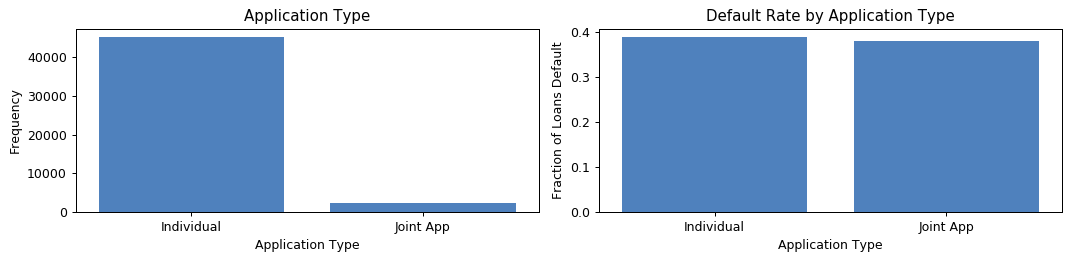

In [8]:
print(dataset.groupby('loan_status')['application_type'].value_counts(dropna=False))
plot_var('application_type', 'Application Type', continuous=False, dataset=dataset)

There does not seem to be a strong correlation between risk and application_type. Both risk around the same percentage.

### Debt to Income Ratio (Numerical)
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

               count       mean        std  min    25%    50%    75%     max
loan_status                                                                 
Default      18486.0  20.346391  12.928459  0.0  13.77  19.98  26.31  886.77
Fully Paid   29126.0  18.066659  13.751295  0.0  11.48  17.19  23.52  999.00


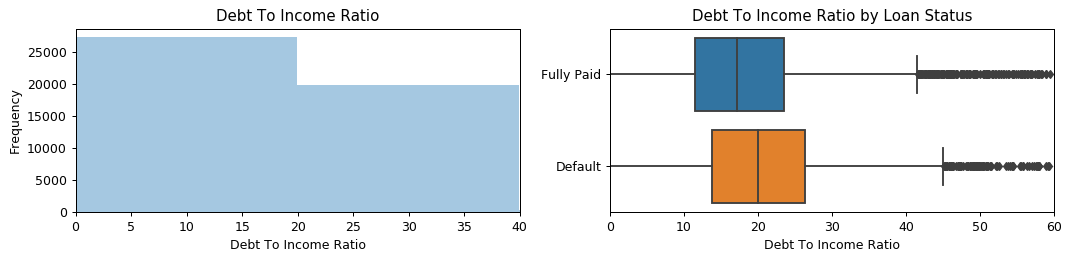

In [9]:
# dummy = dataset.loc[dataset['dti'].notnull() & (dataset['dti']<60), 'dti']
print(dataset.groupby('loan_status')['dti'].describe())
plot_var('dti', 'Debt To Income Ratio', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=40, x2l=0, x2u=60)
# sns.distplot(dataset.loc[dataset['dti'].notnull() & (dataset['dti']<60), 'dti'], kde=False)
# plt.xlabel('Debt-to-income Ratio')
# plt.ylabel('Count')
# plt.title('Debt-to-income Ratio')

It seems that a higher debt to income ratio has a higher probability of charged off

### Delinquency (Categorical)
The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

loan_status  delinq_2yrs
Default      0              14465
             1               2587
             2               1442
Fully Paid   0              23444
             1               3817
             2               1884
Name: delinq_2yrs, dtype: int64


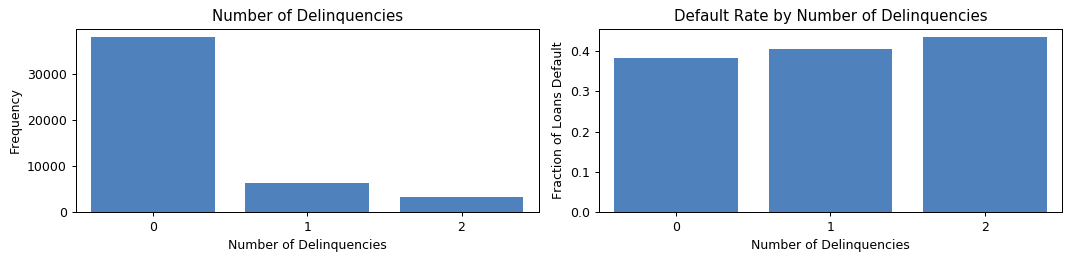

In [10]:
dataset['delinq_2yrs'].values[dataset['delinq_2yrs'] > 1] = 2
print(dataset.groupby('loan_status')['delinq_2yrs'].value_counts(dropna=False))
plot_var('delinq_2yrs', 'Number of Delinquencies', continuous=False, dataset=dataset)

There seems to be an increasing trend in charge-off rate and increasing number of delinquencies but it is small. Whether or not this is significant remains to be seen.

### Earliest Credit Line (Numerical)
The month the borrower's earliest reported credit line was opened.

               count         mean       std     min     25%     50%     75%  \
loan_status                                                                   
Default      18494.0  2000.799773  7.758312  1953.0  1997.0  2002.0  2006.0   
Fully Paid   29145.0  2000.470647  7.565745  1958.0  1997.0  2002.0  2005.0   

                max  
loan_status          
Default      2014.0  
Fully Paid   2014.0  


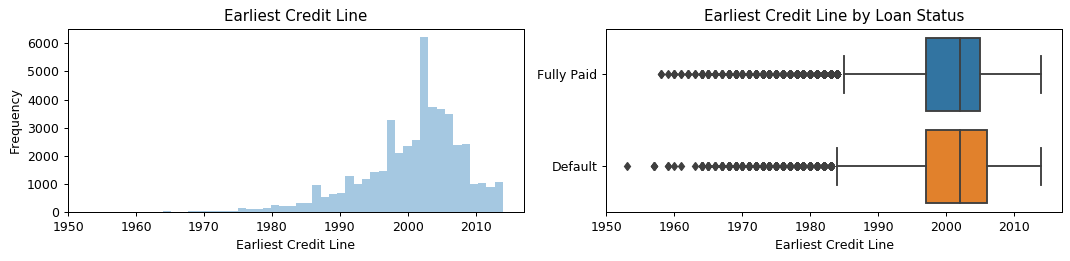

In [11]:
# dataset['earliest_cr_line'] = pd.to_datetime(dataset['earliest_cr_line'], format='%b-%y').dt.year
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-2:]))
dataset.loc[dataset['earliest_cr_line'] > 20, 'earliest_cr_line'] += 1900
dataset.loc[dataset['earliest_cr_line'] < 20, 'earliest_cr_line'] += 2000
print(dataset.groupby('loan_status')['earliest_cr_line'].describe())
plot_var('earliest_cr_line', 'Earliest Credit Line', continuous=True, dataset=dataset)

Surprisingly, when a person first obtained credit seems irrelevant.

### Employment Length (Categorical)
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

loan_status  emp_length
Default      0.0            1541
             1.0            1328
             2.0            1823
             3.0            1581
             4.0            1099
             5.0            1152
             6.0             732
             7.0             650
             8.0             582
             9.0             627
             10.0           5630
             NaN            1749
Fully Paid   0.0            2454
             1.0            1879
             2.0            2654
             3.0            2349
             4.0            1793
             5.0            1788
             6.0            1311
             7.0            1054
             8.0             856
             9.0            1101
             10.0          10213
             NaN            1693
Name: emp_length, dtype: int64


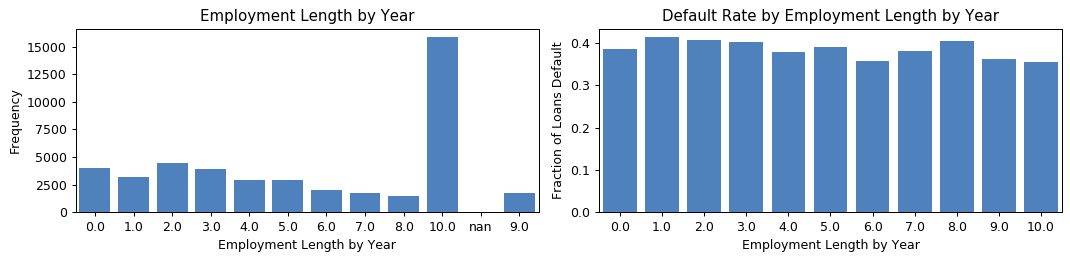

In [12]:
dataset['emp_length'].replace('< 1 year', 0, inplace=True)
dataset['emp_length'].replace('1 year', 1, inplace=True)
dataset['emp_length'].replace('2 years', 2, inplace=True)
dataset['emp_length'].replace('3 years', 3, inplace=True)
dataset['emp_length'].replace('4 years', 4, inplace=True)
dataset['emp_length'].replace('5 years', 5, inplace=True)
dataset['emp_length'].replace('6 years', 6, inplace=True)
dataset['emp_length'].replace('7 years', 7, inplace=True)
dataset['emp_length'].replace('8 years', 8, inplace=True)
dataset['emp_length'].replace('9 years', 9, inplace=True)
dataset['emp_length'].replace('10+ years', 10, inplace=True)
print(dataset.groupby('loan_status')['emp_length'].value_counts(dropna=False).sort_index())
plot_var('emp_length', 'Employment Length by Year', continuous=False, dataset=dataset)

Doesn't seem to be much of a significant pattern here

### Home Ownership (Categorical)
The home ownership status provided by the borrower during registration or obtained from the credit report.

loan_status  home_ownership
Default      RENT               8501
             MORTGAGE           7781
             OWN                2212
Fully Paid   MORTGAGE          15652
             RENT              10148
             OWN                3345
Name: home_ownership, dtype: int64


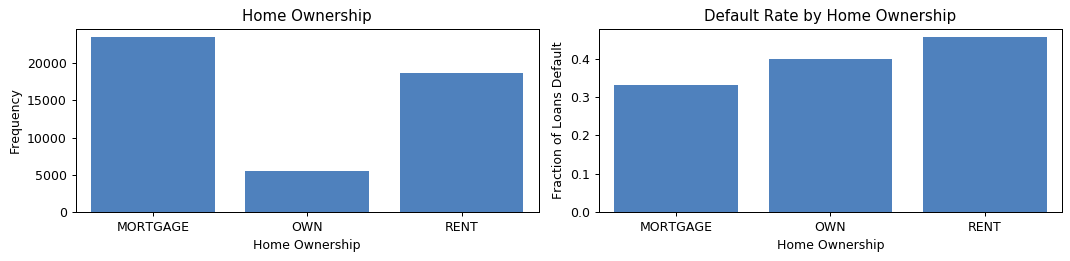

In [13]:
# dataset['home_ownership'].replace(['NONE', 'ANY'], 'NaN', inplace=True)
dataset['home_ownership'].replace(['NONE', 'ANY'], 'MORTGAGE', inplace=True)
print(dataset.groupby('loan_status')['home_ownership'].value_counts(dropna=False))
plot_var('home_ownership', 'Home Ownership', continuous=False, dataset=dataset)
# dataset['home_ownership'].replace('NaN', np.nan, inplace=True)

Interestingly those with a mortgage are more likely to pay off loans and those who rent are the least likely

### Initial List Status (Categorical)
The initial listing status of the loan. Possible values are – W, F

loan_status  initial_list_status
Default      w                      12515
             f                       5979
Fully Paid   w                      21390
             f                       7755
Name: initial_list_status, dtype: int64


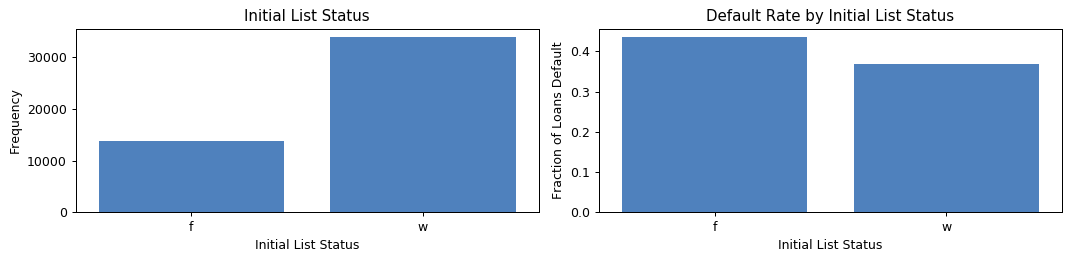

In [14]:
print(dataset.groupby('loan_status')['initial_list_status'].value_counts(dropna=False))
plot_var('initial_list_status', 'Initial List Status', continuous=False, dataset=dataset)

Theres does not seem to be much information gained from Initial List status

### Installment (Numerical)
The monthly payment owed by the borrower if the loan originates.

               count        mean         std    min     25%     50%     75%  \
loan_status                                                                   
Default      18494.0  490.309022  298.855772  30.99  271.45  410.35  659.43   
Fully Paid   29145.0  420.773546  281.422908  30.12  212.75  341.41  559.44   

                 max  
loan_status           
Default      1566.80  
Fully Paid   1587.23  
               count      mean       std       min       25%       50%  \
loan_status                                                              
Default      18494.0  5.995530  0.676362  3.465423  5.607455  6.019444   
Fully Paid   29145.0  5.811583  0.722315  3.437851  5.364807  5.836009   

                  75%       max  
loan_status                      
Default      6.492891  7.357429  
Fully Paid   6.328722  7.370375  


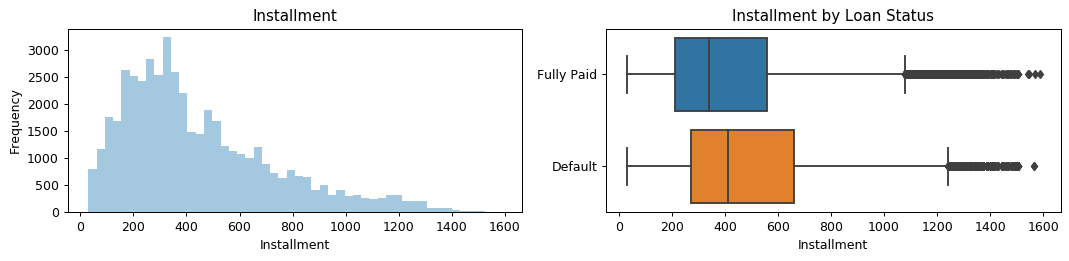

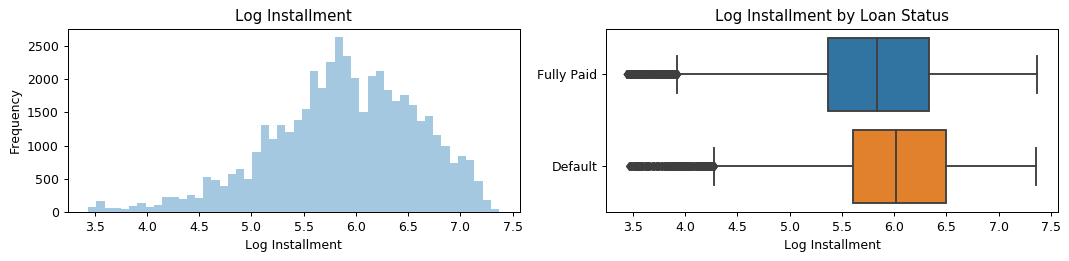

In [15]:
print(dataset.groupby('loan_status')['installment'].describe())
plot_var('installment', 'Installment', continuous=True, dataset=dataset)
# since the plot is left skewed, we take the log transformation
dataset['log_installment'] = dataset['installment'].apply(lambda x: np.log(x + 1))
dataset.drop('installment', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_installment'].describe())
plot_var('log_installment', 'Log Installment', continuous=True, dataset=dataset)

It seems those with higher installments are more likely to be charged off

### Interest Rate (Numerical)
Interest Rate on the loan

               count       mean       std   min    25%    50%    75%    max
loan_status                                                                
Default      18494.0  16.556265  5.858256  5.32  12.74  15.05  18.99  30.99
Fully Paid   29145.0  13.215077  5.276465  5.32   9.93  12.62  15.99  30.99


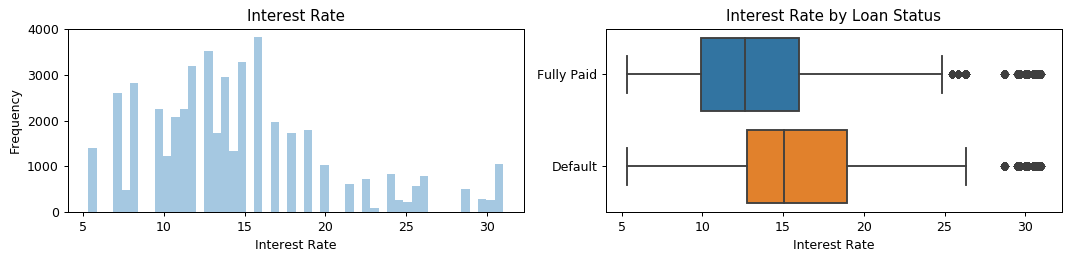

In [16]:
dataset['int_rate'] = dataset['int_rate'].str.rstrip('%').astype('float')
print(dataset.groupby('loan_status')['int_rate'].describe())
plot_var('int_rate', 'Interest Rate', continuous=True, dataset=dataset)

There seems to be a much higher interest rate on average for loans that charge off

### Loan Amount (Numerical)
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

               count          mean          std     min     25%      50%  \
loan_status                                                                
Default      18494.0  15645.820266  9411.036948  1000.0  8000.0  14000.0   
Fully Paid   29145.0  13690.972723  9244.813927  1000.0  6400.0  11200.0   

                 75%      max  
loan_status                    
Default      21000.0  40000.0  
Fully Paid   19200.0  40000.0  


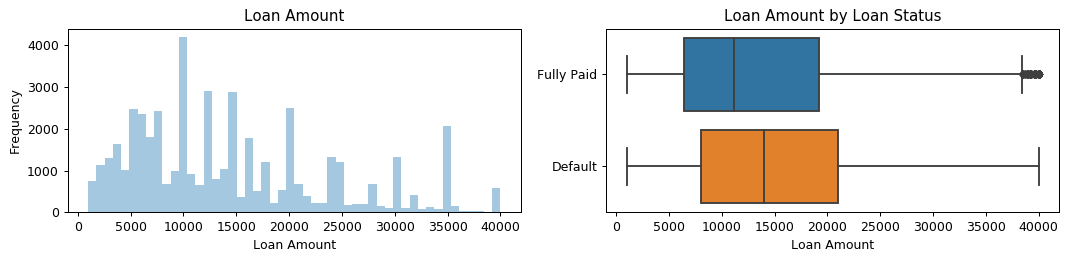

In [17]:
print(dataset.groupby('loan_status')['loan_amnt'].describe())
plot_var('loan_amnt', 'Loan Amount', continuous=True, dataset=dataset)

It seems charged off loans have a higher loan amount

### Mortgage Accounts (Numerical)
Number of mortgage accounts

loan_status  mort_acc
Default      0            9093
             1            3457
             2            2514
             3            1639
             4             914
             5             475
             6             216
             7             100
             8              42
             9              28
             10             16
Fully Paid   0           11003
             1            5592
             2            4767
             3            3288
             4            2163
             5            1118
             6             608
             7             290
             8             171
             10             80
             9              65
Name: mort_acc, dtype: int64


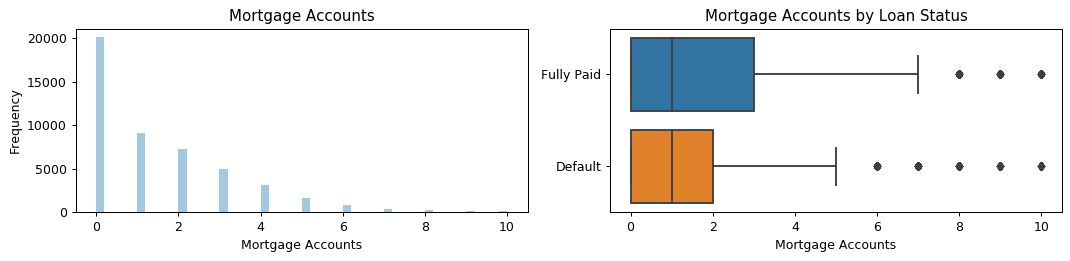

In [18]:
dataset.loc[dataset['mort_acc'] > 9, 'mort_acc'] = 10
print(dataset.groupby('loan_status')['mort_acc'].value_counts(dropna=False))
plot_var('mort_acc', 'Mortgage Accounts', continuous=True, dataset=dataset)

Currently there does not seem to be a significant difference

### Open Account (Numerical)
The number of open credit lines in the borrower's credit file.

               count       mean       std  min  25%   50%   75%   max
loan_status                                                          
Default      18494.0  11.944306  5.770755  1.0  8.0  11.0  15.0  68.0
Fully Paid   29145.0  11.825630  5.743959  0.0  8.0  11.0  15.0  88.0


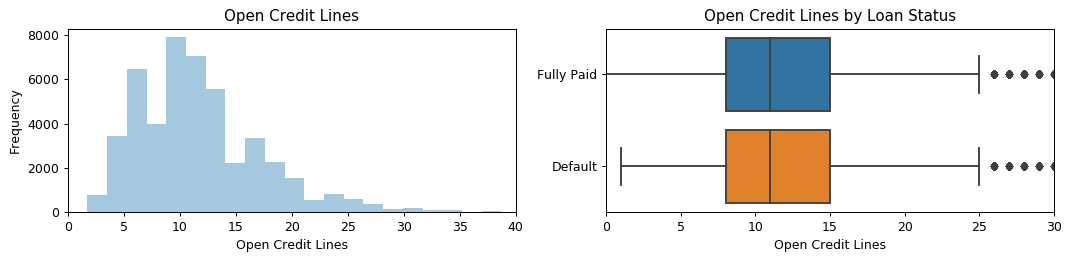

In [19]:
print(dataset.groupby('loan_status')['open_acc'].describe())
plot_var('open_acc', 'Open Credit Lines', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=40, x2l=0, x2u=30)

Does not seem to be a good indicator of risk

### Public Record (Categorical)
Number of derogatory public records

loan_status  pub_rec     
Default      None            14254
             At least one     4240
Fully Paid   None            22937
             At least one     6208
Name: pub_rec, dtype: int64


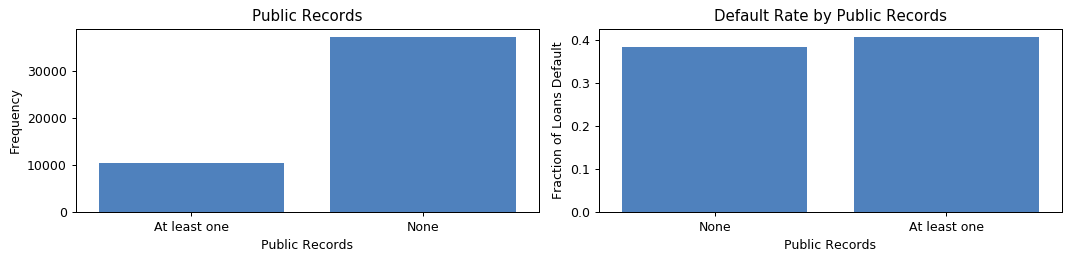

In [20]:
dataset['pub_rec'] = pd.cut(dataset['pub_rec'], [0, 0.9, 25], labels=['None', 'At least one'], include_lowest=True)
print(dataset.groupby('loan_status')['pub_rec'].value_counts(dropna=False))
plot_var('pub_rec', 'Public Records', continuous=False, dataset=dataset)

Loan default rate does not seem to change much by derogatory public records

### Public Record of Bankruptcies (Categorical)
Number of public record bankruptcies

loan_status  pub_rec_bankruptcies
Default      None                    15508
             At least one             2986
Fully Paid   None                    24732
             At least one             4413
Name: pub_rec_bankruptcies, dtype: int64


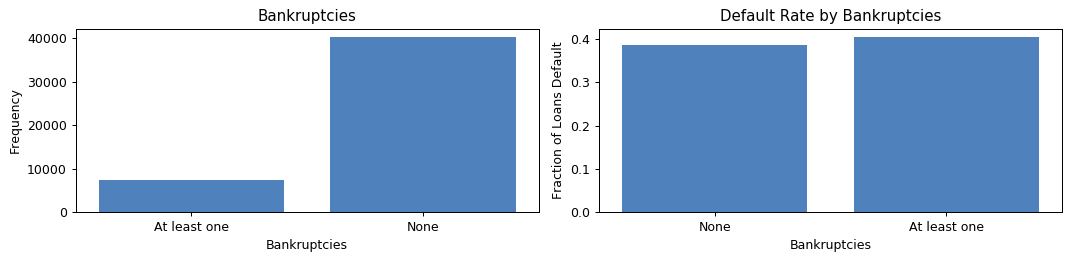

In [21]:
dataset['pub_rec_bankruptcies'] = pd.cut(dataset['pub_rec_bankruptcies'], [0, 0.9, 25], 
                                         labels=['None', 'At least one'], include_lowest=True)
print(dataset.groupby('loan_status')['pub_rec_bankruptcies'].value_counts(dropna=False))
plot_var('pub_rec_bankruptcies', 'Bankruptcies', continuous=False, dataset=dataset)

Loan default rate does not seem to change much by public bankruptcies records

### Purpose (Categorical)
A category provided by the borrower for the loan request

In [22]:
dataset.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:, 'Default'].sort_values()

purpose
car                   0.294828
home_improvement      0.323486
vacation              0.330827
house                 0.337255
major_purchase        0.351542
credit_card           0.368047
other                 0.397081
debt_consolidation    0.403409
moving                0.415217
renewable_energy      0.419355
medical               0.420624
small_business        0.577143
Name: loan_status, dtype: float64

### Revolving Balance (Numerical)
Total credit revolving balance

               count          mean           std  min      25%      50%  \
loan_status                                                               
Default      18494.0  15708.679734  17434.382178  0.0  6293.25  11532.0   
Fully Paid   29145.0  15601.315080  24339.574929  0.0  5176.00  10103.0   

                  75%        max  
loan_status                       
Default      19428.75   354794.0  
Fully Paid   18214.00  1039013.0  
               count      mean       std  min       25%       50%       75%  \
loan_status                                                                   
Default      18494.0  9.226252  1.132146  0.0  8.747392  9.352968  9.874561   
Fully Paid   29145.0  9.078444  1.308805  0.0  8.551981  9.220687  9.810001   

                   max  
loan_status             
Default      12.779295  
Fully Paid   13.853783  


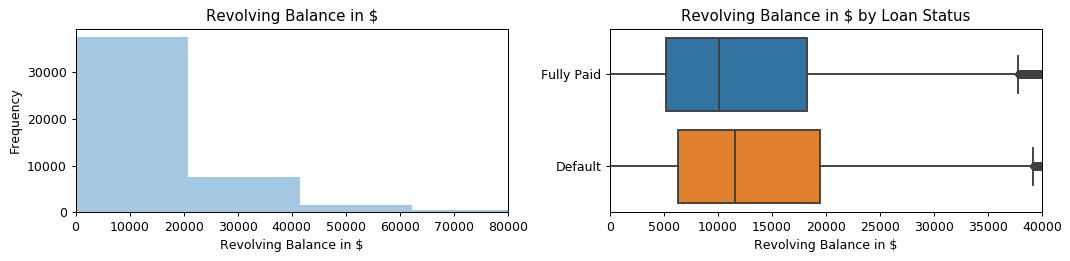

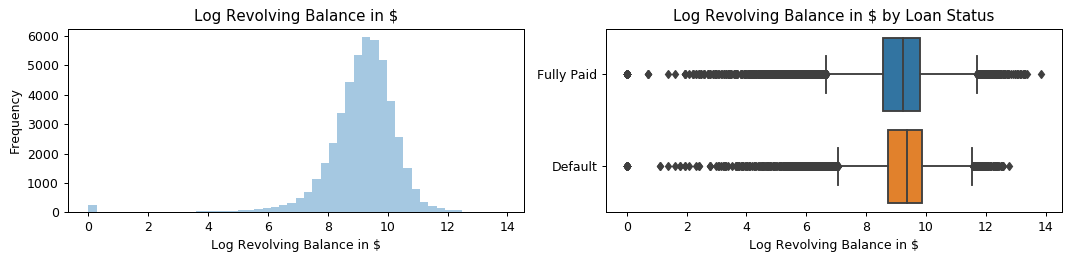

In [23]:
print(dataset.groupby('loan_status')['revol_bal'].describe())
plot_var('revol_bal', 'Revolving Balance in $', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=80000, x2l=0, x2u=40000)
# Seems like the data is heavily right skewed with a large range due to large outliers so we take the log transformation
dataset['log_revol_bal'] = dataset['revol_bal'].apply(lambda x: np.log(x + 1))
dataset.drop('revol_bal', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_revol_bal'].describe())
plot_var('log_revol_bal', 'Log Revolving Balance in $', continuous=True, dataset=dataset)

There is not much difference in the two categories for revolving balances

### Revolving Utility (Numerical)
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

               count       mean        std  min   25%   50%   75%    max
loan_status                                                             
Default      18488.0  52.649946  23.650179  0.0  35.3  52.9  70.3  138.9
Fully Paid   29120.0  44.685968  24.521824  0.0  25.4  43.3  62.9  125.2


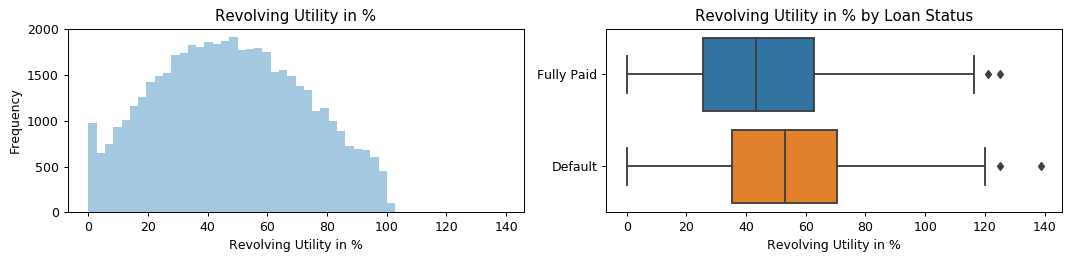

In [24]:
dataset['revol_util'] = dataset['revol_util'].str.rstrip('%').astype('float')
print(dataset.groupby('loan_status')['revol_util'].describe())
plot_var('revol_util', 'Revolving Utility in %', continuous=True, dataset=dataset)

It seems those with a lower revolving utility are more likely to pay off their loans

### Grade (Categorical)
LendingClub assigned loan grade. The higher the letter, the safer the loan.

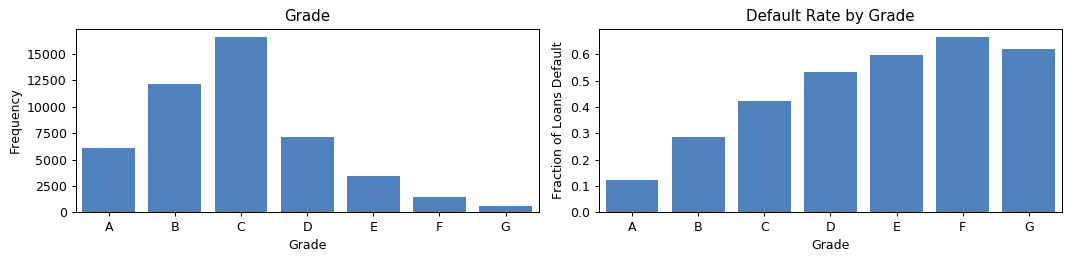

In [25]:
plot_var('grade', 'Grade', continuous=False, dataset=dataset)

There seems to be a strong trend between charge off rate and deteriorating grade

### Term (Categorical)
The number of payments on the loan. Values are in months and can be either 36 or 60

loan_status  term
Default      36      12599
             60       5895
Fully Paid   36      23073
             60       6072
Name: term, dtype: int64


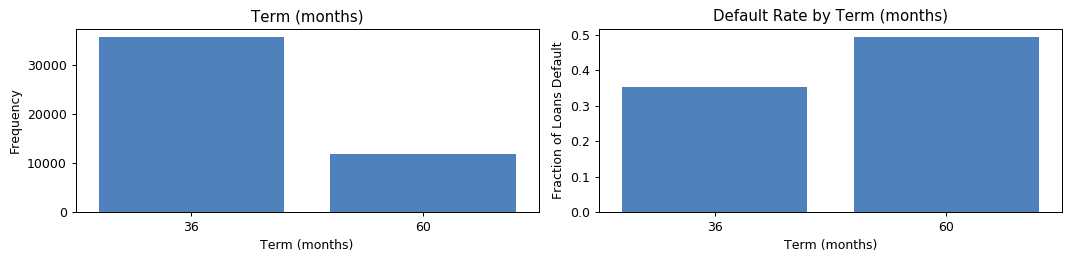

In [26]:
# dataset['term'].replace('36 months', 36, inplace=True)
# dataset['term'].replace('60 months', 60, inplace=True)
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))
print(dataset.groupby('loan_status')['term'].value_counts(dropna=False))
plot_var('term', 'Term (months)', continuous=False, dataset=dataset)

Loan Duration or how long to maturity seems to be important and a good indicator of risk of default. A longer duration has a higher risk that the loan will not be repaid.  

### Total Accounts (Numerical)
The total number of credit lines currently in the borrower's credit file

               count       mean        std  min   25%   50%   75%    max
loan_status                                                             
Default      18494.0  23.766843  11.858529  2.0  15.0  22.0  30.0  121.0
Fully Paid   29145.0  24.859633  12.233984  2.0  16.0  23.0  31.0  146.0


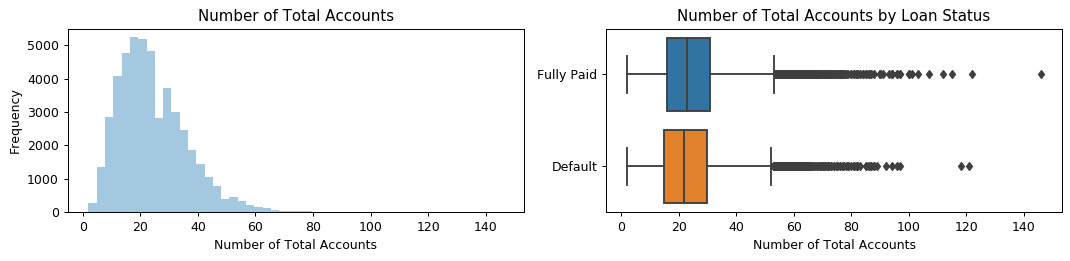

In [27]:
print(dataset.groupby('loan_status')['total_acc'].describe())
plot_var('total_acc', 'Number of Total Accounts', continuous=True, dataset=dataset)

There does not seem to be a significant difference in charge off rate depending on the total account number

### Verification Status (Categorical)
Indicates if income was verified, not verified, or if the income source was verified.

loan_status  verification_status
Default      Source Verified         7559
             Verified                6761
             Not Verified            4174
Fully Paid   Source Verified        11607
             Not Verified           10330
             Verified                7208
Name: verification_status, dtype: int64


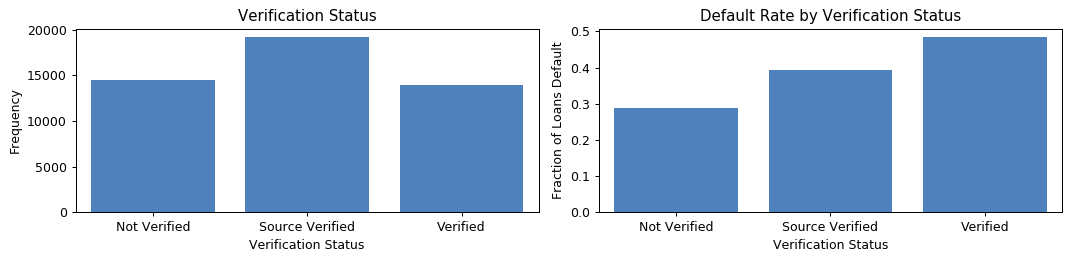

In [28]:
print(dataset.groupby('loan_status')['verification_status'].value_counts(dropna=False))
plot_var('verification_status', 'Verification Status', continuous=False, dataset=dataset)

There seems to be a strong linear trend between charged off rate and verification status. Surprisingly, loans with a status of verified have a higher chance of becoming charged off.

# Preliminary Model Design

### Create dummy variables
1(negative class) means charged-off and 0(positive class) means fully paid and create dummy variables for all categorical variables

In [29]:
dataset['loan_status'].replace('Default', 1, inplace=True)
dataset['loan_status'].replace('Fully Paid', 0, inplace=True)

dataset = pd.get_dummies(dataset, columns=['grade', 'home_ownership', 'verification_status', 'purpose', 
                                           'initial_list_status', 'application_type', 'pub_rec', 
                                           'pub_rec_bankruptcies'], drop_first=True)
dataset.head()

,loan_amnt,term,int_rate,emp_length,loan_status,dti,delinq_2yrs,earliest_cr_line,open_acc,revol_util,total_acc,total_pymnt,mort_acc,log_annual_inc,log_installment,log_revol_bal,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,pub_rec_At least one,pub_rec_bankruptcies_At least one
0,5000,36,7.35,5.0,0,15.76,0,2004,12,13.2,25,5385.245133,1,11.002117,5.051073,8.215547,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,7500,36,7.35,7.0,0,13.12,0,2013,19,27.2,27,7642.289180,4,11.608245,5.454423,10.058309,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,9600,36,7.97,0.0,0,18.34,0,2005,16,48.6,44,10283.629660,3,11.849405,5.709433,9.376617,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2000,36,7.07,2.0,0,12.15,0,2005,9,0.3,12,2097.014574,0,11.289794,4.140273,3.663562,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,7200,36,24.85,2.0,0,6.07,0,2000,4,98.9,5,7206.461000,0,10.819798,5.658436,8.177797,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


### Split the data

In [30]:
dataset.dropna(inplace=True)
# dataset.fillna(lambda x: x.median())
y = dataset.loc[:, dataset.columns == 'loan_status']
x = dataset.loc[:, dataset.columns != 'loan_status']
# y = dataset['loan_status']
# X = dataset.drop(columns=['loan_status'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, 
                                                    stratify=dataset['loan_status'])

x_train.drop('total_pymnt', axis=1, inplace=True)
test_pymnts = x_test.loc[:, x_test.columns == 'total_pymnt']
x_test.drop('total_pymnt', axis=1, inplace=True)

# x_train = x_train.reset_index()
# y_train = y_train.reset_index()

c:\users\leon\miniconda3\envs\aiml\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Feature Selection and Model Fitting

### Logistic Regression Model

#### Base

In [31]:
model_lr_base = LogisticRegression(penalty="l2",
                                   C=0.5,
                                   fit_intercept=True,
                                   random_state=0,
                                   max_iter=10000,
                                   solver='lbfgs')
model_lr_base.fit(x_train, y_train.values.ravel())

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Cost Sensitive Method

In [32]:
model_lr = LogisticRegression(penalty="l2",
                              C=0.5,
                              fit_intercept=True,
                              class_weight='balanced',
                              random_state=0,
                              max_iter=10000,
                              solver='lbfgs')
model_lr = model_lr.fit(x_train, y_train.values.ravel())

In [33]:
import statsmodels.api as sm
logit_model = sm.Logit(y, x)
result = logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.015635
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Logit
====================================================================================
Model:                      Logit                  Pseudo R-squared:       0.976    
Dependent Variable:         loan_status            AIC:                    1461.1080
Date:                       2019-10-30 08:20       BIC:                    1808.9373
No. Observations:           44167                  Log-Likelihood:         -690.55  
Df Model:                   39                     LL-Null:                -29308.  
Df Residuals:               44127                  LLR p-value:            0.0000   
Converged:                  1.0000                 Scale:                  1.0000   
No. Iterations:             14.0000                                                 
------------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------
loan_amnt                            0.0051   0.0002  31.9155 0.0000  0.0048  0.0054
term                                -0.0512   0.0184  -2.7819 0.0054 -0.0873 -0.0151
int_rate                             0.0638   0.0724   0.8804 0.3787 -0.0782  0.2057
emp_length                          -0.0012   0.0230  -0.0522 0.9584 -0.0463  0.0439
dti                                  0.0084   0.0106   0.7943 0.4270 -0.0123  0.0291
delinq_2yrs                          0.2104   0.1332   1.5791 0.1143 -0.0507  0.4715
earliest_cr_line                     0.0025   0.0012   2.0681 0.0386  0.0001  0.0049
open_acc                             0.0415   0.0222   1.8681 0.0617 -0.0020  0.0850
revol_util                           0.0105   0.0042   2.5282 0.0115  0.0024  0.0186
total_acc                           -0.0107   0.0107  -0.9991 0.3178 -0.0316  0.0103
total_pymnt                         -0.0049   0.0002 -31.3356 0.0000 -0.0052 -0.0046
mort_acc                             0.0110   0.0647   0.1702 0.8649 -0.1158  0.1378
log_annual_inc                      -0.2491   0.1977  -1.2598 0.2077 -0.6366  0.1384
log_installment                     -1.5293   0.1870  -8.1799 0.0000 -1.8958 -1.1629
log_revol_bal                       -0.0575   0.0783  -0.7340 0.4629 -0.2109  0.0960
grade_B                              0.3078   0.4038   0.7623 0.4459 -0.4836  1.0992
grade_C                              0.7029   0.5883   1.1947 0.2322 -0.4502  1.8559
grade_D                              1.0094   0.8874   1.1374 0.2554 -0.7299  2.7486
grade_E                              0.8045   1.3145   0.6120 0.5405 -1.7718  3.3809
grade_F                              0.2924   1.7724   0.1650 0.8690 -3.1814  3.7662
grade_G                              1.8290   1.8524   0.9874 0.3235 -1.8016  5.4596
home_ownership_OWN                   0.2594   0.2551   1.0171 0.3091 -0.2405  0.7593
home_ownership_RENT                  0.0827   0.2142   0.3859 0.6996 -0.3372  0.5025
verification_status_Source Verified  0.3925   0.2123   1.8489 0.0645 -0.0236  0.8086
verification_status_Verified         0.2522   0.2488   1.0135 0.3108 -0.2355  0.7399
purpose_credit_card                  0.5843   0.7025   0.8318 0.4055 -0.7925  1.9611
purpose_debt_consolidation           0.4451   0.6784   0.6561 0.5118 -0.8846  1.7748
purpose_home_improvement             0.7780   0.7137   1.0900 0.2757 -0.6209  2.1769
purpose_house                        0.6895   1.0535   0.6545 0.5128 -1.3754  2.7543
purpose_major_purchase               0.2848   0.8008   0.3557 0.7221 -1.2846  1.8543
purpose_medical                      0.6742   0.7594   0.8878 0.3747 -0.8143  2.1627
purpose_moving                       0.2560   0.8431   0.3037 0.7614 -1.3964  1.9085
purpose_other                        0.4449   0.6903   0.6446 0.5192 -0.9080  1.7978
purpose_renewable_energy             0.4863   1.5947   0.3050 0.7604 -2.6393

We remove all variables with p-value less than 0.05

In [34]:
result.pvalues[result.pvalues > 0.05]

int_rate                               0.378662
emp_length                             0.958403
dti                                    0.427021
delinq_2yrs                            0.114316
open_acc                               0.061749
total_acc                              0.317753
mort_acc                               0.864878
log_annual_inc                         0.207726
log_revol_bal                          0.462941
grade_B                                0.445874
grade_C                                0.232199
grade_D                                0.255358
grade_E                                0.540510
grade_F                                0.868953
grade_G                                0.323465
home_ownership_OWN                     0.309099
home_ownership_RENT                    0.699561
verification_status_Source Verified    0.064475
verification_status_Verified           0.310800
purpose_credit_card                    0.405548
purpose_debt_consolidation             0

In [35]:
keep_list = list(result.pvalues[result.pvalues < 0.05].index)
keep_list.append('loan_status')
drop_list = [col for col in dataset.columns if col not in keep_list]
x_train_lr = x_train.drop(labels=drop_list, axis=1)
x_test_lr = x_test.drop(labels=drop_list, axis=1)
model_lr2 = LogisticRegression(penalty="l2", C=0.5, fit_intercept=True, class_weight='balanced',
                               random_state=0, max_iter=10000, solver='lbfgs')
model_lr2.fit(x_train_lr, y_train.values.ravel())

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

#### Sampling Method - SMOTE

In [36]:
x_train_lr_sm, y_train_sm = SMOTE(random_state=1).fit_resample(x_train, y_train.values.ravel())
model_lr_smote = LogisticRegression(penalty="l2",
                                    C=0.5,
                                    fit_intercept=True,
                                    random_state=0,
                                    max_iter=10000,
                                    solver='lbfgs')
model_lr_smote.fit(x_train_lr_sm, y_train_sm)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Sampling Method - ADASYN

In [37]:
x_train_lr_as, y_train_as = ADASYN(random_state=1).fit_sample(x_train, y_train.values.ravel())
model_lr_adasyn = LogisticRegression(penalty="l2", 
                                     C=0.5, fit_intercept=True, 
                                     random_state=0, 
                                     max_iter=10000, 
                                     solver='lbfgs')
model_lr_adasyn.fit(x_train_lr_as, y_train_as)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Logistic Regression Results

#### Base

In [38]:
# Make predictions and determine the error
y_pred_lr = model_lr_base.predict(x_test)
print("Accuracy: %.2f%%" % (model_lr_base.score(x_test, y_test) * 100))
print(confusion_matrix(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
# predict probabilities
prob = model_lr_base.predict_proba(x_test)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_lr, recall_lr, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_lr, precision_lr))

Accuracy: 65.70%
[[7134 1095]
 [3450 1572]]
F1 Score: 0.4088958252048381
              precision    recall  f1-score   support

           0       0.67      0.87      0.76      8229
           1       0.59      0.31      0.41      5022

    accuracy                           0.66     13251
   macro avg       0.63      0.59      0.58     13251
weighted avg       0.64      0.66      0.63     13251

PR-AUC:  0.5464040971217461


#### Cost Sensitive Method

In [39]:
# Make predictions and determine the error
y_pred_lr = model_lr.predict(x_test)
print("Accuracy: %.2f%%" % (model_lr.score(x_test, y_test) * 100))
print(confusion_matrix(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
# predict probabilities
prob = model_lr.predict_proba(x_test)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_lr, recall_lr, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_lr, precision_lr))

Accuracy: 64.03%
[[5503 2726]
 [2041 2981]]
F1 Score: 0.5556901854786094
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      8229
           1       0.52      0.59      0.56      5022

    accuracy                           0.64     13251
   macro avg       0.63      0.63      0.63     13251
weighted avg       0.65      0.64      0.64     13251

PR-AUC:  0.5464973303519882


In [40]:
y_pred_lr2 = model_lr2.predict(x_test_lr)
print("Accuracy: %.2f%%" % (model_lr2.score(x_test_lr, y_test) * 100))
print(confusion_matrix(y_test, y_pred_lr2))
print('F1 Score:', f1_score(y_test, y_pred_lr2))
print(classification_report(y_test, y_pred_lr2))
prob = model_lr2.predict_proba(x_test_lr)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_lr, recall_lr, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_lr, precision_lr))

Accuracy: 58.94%
[[4733 3496]
 [1945 3077]]
F1 Score: 0.5307460112117292
              precision    recall  f1-score   support

           0       0.71      0.58      0.64      8229
           1       0.47      0.61      0.53      5022

    accuracy                           0.59     13251
   macro avg       0.59      0.59      0.58     13251
weighted avg       0.62      0.59      0.60     13251

PR-AUC:  0.4993774441315906


In [41]:
# manually picked
important_indices = ['log_annual_inc',
                     'dti',
                     'home_ownership_OWN',
                     'home_ownership_RENT',
                     'log_installment',
                     'int_rate',
                     'loan_amnt',
                     'revol_util',
                     'grade_B',
                     'grade_C',
                     'grade_D',
                     'grade_E',
                     'grade_F',
                     'grade_G',
                     'term',
                     'verification_status_Source Verified',
                     'verification_status_Verified']
x_train_lr = x_train.loc[:, important_indices]
x_test_lr = x_test.loc[:, important_indices]
model_lr3 = LogisticRegression(penalty="l2", C=0.5, fit_intercept=True, class_weight='balanced',
                               random_state=0, max_iter=10000, solver='lbfgs')
model_lr3 = model_lr3.fit(x_train_lr, y_train.values.ravel())
y_pred_lr = model_lr3.predict(x_test_lr)
print("Accuracy: %.2f%%" % (model_lr3.score(x_test_lr, y_test) * 100))
confusion_matrix(y_test, y_pred_lr)
print('F1 Score:', f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
# predict probabilities
prob = model_lr3.predict_proba(x_test_lr)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_lr, recall_lr, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_lr, precision_lr))

Accuracy: 63.86%
F1 Score: 0.5538891476478808
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      8229
           1       0.52      0.59      0.55      5022

    accuracy                           0.64     13251
   macro avg       0.62      0.63      0.63     13251
weighted avg       0.65      0.64      0.64     13251

PR-AUC:  0.5416129481431338


#### Sampling Method - SMOTE

In [42]:
# Make predictions and determine the error
y_pred_lr = model_lr_smote.predict(x_test)
print("Accuracy: %.2f%%" % (model_lr_smote.score(x_test, y_test) * 100))
print(confusion_matrix(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
# predict probabilities
prob = model_lr_smote.predict_proba(x_test)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_lr, recall_lr, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_lr, precision_lr))

Accuracy: 64.49%
[[5376 2853]
 [1852 3170]]
F1 Score: 0.5740153915799003
              precision    recall  f1-score   support

           0       0.74      0.65      0.70      8229
           1       0.53      0.63      0.57      5022

    accuracy                           0.64     13251
   macro avg       0.64      0.64      0.63     13251
weighted avg       0.66      0.64      0.65     13251

PR-AUC:  0.558655682201526


#### Sampling Method - ADASYN

In [43]:
# Make predictions and determine the error
y_pred_lr = model_lr_adasyn.predict(x_test)
print("Accuracy: %.2f%%" % (model_lr_adasyn.score(x_test, y_test) * 100))
print(confusion_matrix(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
# predict probabilities
prob = model_lr_adasyn.predict_proba(x_test)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_lr, recall_lr, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_lr, precision_lr))

Accuracy: 63.95%
[[5434 2795]
 [1982 3040]]
F1 Score: 0.5600073685180068
              precision    recall  f1-score   support

           0       0.73      0.66      0.69      8229
           1       0.52      0.61      0.56      5022

    accuracy                           0.64     13251
   macro avg       0.63      0.63      0.63     13251
weighted avg       0.65      0.64      0.64     13251

PR-AUC:  0.5459631714046866


### Random Forest Model

50
100
250
500
1000
1500
2500


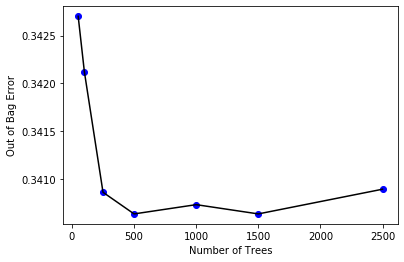

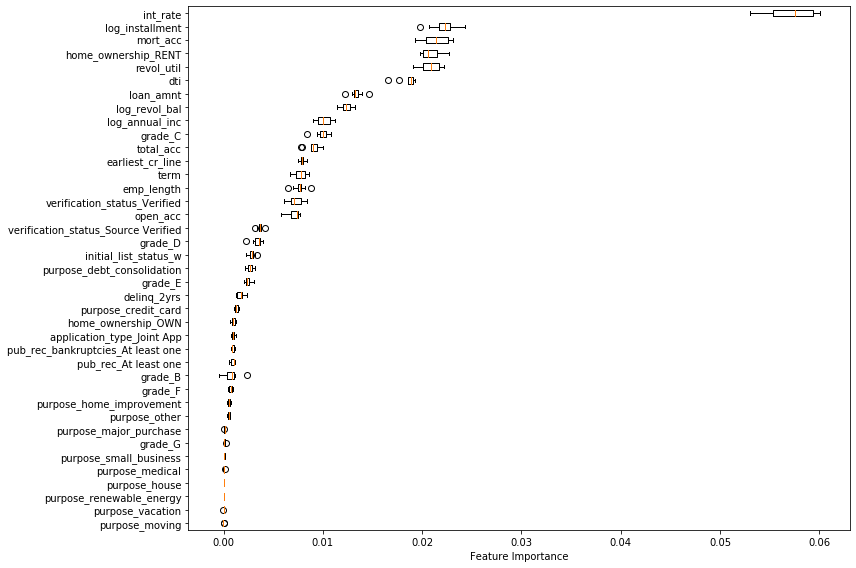

In [44]:
model_rf_path = Path('../data/model_rf.joblib')
if os.path.exists(model_rf_path): # list of features files does not exist dont save model
    model_rf = load(model_rf_path)
else:
    n_trees = [50, 100, 250, 500, 1000, 1500, 2500]
    rf_dict = dict.fromkeys(n_trees)
    for num in n_trees:
        print(num)
        rf = RandomForestClassifier(n_estimators=num,
                                    min_samples_leaf=30,
                                    oob_score=True,
                                    random_state=100,
                                    class_weight='balanced',
                                    n_jobs=-1)
        rf.fit(x_train, y_train.values.ravel())
        rf_dict[num] = rf

    oob_error_list = [None] * len(n_trees)

    for i in range(len(n_trees)):
        oob_error_list[i] = 1 - rf_dict[n_trees[i]].oob_score_

    plt.plot(n_trees, oob_error_list, 'bo', n_trees, oob_error_list, 'k')
    plt.xlabel('Number of Trees')
    plt.ylabel('Out of Bag Error')
    model_rf = rf_dict[500]
    
    # calculate permutation feature importance
    result = permutation_importance(model_rf, x_train, y_train, n_repeats=10, random_state=42)
    perm_sorted_idx = result.importances_mean.argsort()

    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
                labels=x_train.columns[perm_sorted_idx])
    ax1.set_xlabel('Feature Importance')
    fig.tight_layout()
    plt.show()

In [45]:
# manually picked
important_indices = ['log_annual_inc',
                     'dti',
                     'home_ownership_OWN',
                     'home_ownership_RENT',
                     'log_installment',
                     'int_rate',
                     'loan_amnt',
                     'revol_util',
                     'grade_B',
                     'grade_C',
                     'grade_D',
                     'grade_E',
                     'grade_F',
                     'grade_G',
                     'term',
                     'verification_status_Source Verified',
                     'verification_status_Verified']
x_train_rf = x_train.loc[:, important_indices]
x_test_rf = x_test.loc[:, important_indices]

#### Base Model

In [46]:
model_rf_base_path = Path('../data/model_rf_base.joblib')
if os.path.exists(model_rf_base_path):
    model_rf_base = load(model_rf_base_path)
else:
    model_rf_base = RandomForestClassifier(n_estimators=500,
                                        min_samples_leaf=30,
                                        oob_score=True,
                                        random_state=100,
                                        n_jobs=-1)
    model_rf_base.fit(x_train_rf, y_train.values.ravel())
    dump(model_rf_base, model_rf_base_path)

#### Class Sensetive Method

In [47]:
model_rf_path = Path('../data/model_rf.joblib')
if os.path.exists(model_rf_path):
    model_rf = load(model_rf_path)
else:
    model_rf = RandomForestClassifier(n_estimators=500,
                                        min_samples_leaf=30,
                                        oob_score=True,
                                        random_state=100,
                                        class_weight='balanced',
                                        n_jobs=-1)
    model_rf.fit(x_train_rf, y_train.values.ravel())
    dump(model_rf, model_rf_path)

#### Sampling - SMOTE Method

In [48]:
model_rf_smote_path = Path('../data/model_rf_smote.joblib')
if os.path.exists(model_rf_smote_path):
    model_rf_smote = load(model_rf_smote_path)
else:
    x_train_rf_sm, y_train_sm = SMOTE(random_state=1).fit_resample(x_train_rf, y_train.values.ravel())
    model_rf_smote = RandomForestClassifier(n_estimators=500,
                                        min_samples_leaf=30,
                                        oob_score=True,
                                        random_state=100,
                                        n_jobs=-1)
    model_rf_smote.fit(x_train_rf_sm, y_train_sm)
    dump(model_rf_smote, model_rf_smote_path)

#### Sampling - ADASYN Method

In [49]:
model_rf_adasyn_path = Path('../data/model_rf_adasyn.joblib')
if os.path.exists(model_rf_adasyn_path):
    model_rf_adasyn = load(model_rf_adasyn_path)
else:
    x_train_rf_as, y_train_as = ADASYN(random_state=1).fit_sample(x_train_rf, y_train.values.ravel())
    model_rf_adasyn = RandomForestClassifier(n_estimators=500,
                                        min_samples_leaf=30,
                                        oob_score=True,
                                        random_state=100,
                                        n_jobs=-1)
    model_rf_adasyn.fit(x_train_rf_as, y_train_as)
    dump(model_rf_adasyn, model_rf_adasyn_path)

### Random Forest Results

#### Base

In [50]:
# Make predictions and determine the error
y_pred_rf = model_rf_base.predict(x_test_rf)
print("Accuracy: %.2f%%" % (model_rf_base.score(x_test_rf, y_test) * 100))
print(confusion_matrix(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
# predict probabilities
prob = model_rf_base.predict_proba(x_test_rf)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_rf, recall_rf, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_rf, precision_rf))

Accuracy: 67.73%
[[6816 1413]
 [2863 2159]]
F1 Score: 0.502443565278101
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      8229
           1       0.60      0.43      0.50      5022

    accuracy                           0.68     13251
   macro avg       0.65      0.63      0.63     13251
weighted avg       0.67      0.68      0.66     13251

PR-AUC:  0.593429439597816


#### Cost Sensitive Methods

In [51]:
y_pred_rf = model_rf.predict(x_test_rf)
print("Accuracy: %.2f%%" % (model_rf.score(x_test_rf, y_test) * 100))
print(confusion_matrix(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
prob = model_rf.predict_proba(x_test_rf)
preds = prob[:,1]
precision_rf, recall_rf, threshold = precision_recall_curve(y_test, preds)
print('PR-AUC: ', auc(recall_rf, precision_rf))

Accuracy: 65.67%
[[5234 2995]
 [1554 3468]]
F1 Score: 0.6039181541140619
              precision    recall  f1-score   support

           0       0.77      0.64      0.70      8229
           1       0.54      0.69      0.60      5022

    accuracy                           0.66     13251
   macro avg       0.65      0.66      0.65     13251
weighted avg       0.68      0.66      0.66     13251

PR-AUC:  0.5934318794159843


#### Sampling Methods - SMOTE

In [52]:
y_pred_rf = model_rf_smote.predict(x_test_rf)
print("Accuracy: %.2f%%" % (model_rf_smote.score(x_test_rf, y_test) * 100))
print(confusion_matrix(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
prob = model_rf_smote.predict_proba(x_test_rf)
preds = prob[:,1]
precision_rf, recall_rf, threshold = precision_recall_curve(y_test, preds)
print('PR-AUC: ', auc(recall_rf, precision_rf))

Accuracy: 67.99%
[[6404 1825]
 [2416 2606]]
F1 Score: 0.5513593568179413
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      8229
           1       0.59      0.52      0.55      5022

    accuracy                           0.68     13251
   macro avg       0.66      0.65      0.65     13251
weighted avg       0.67      0.68      0.68     13251

PR-AUC:  0.5930660640408101


#### Sampling Methods - ADASYN

In [53]:
y_pred_rf = model_rf_adasyn.predict(x_test_rf)
print("Accuracy: %.2f%%" % (model_rf_adasyn.score(x_test_rf, y_test) * 100))
print(confusion_matrix(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
prob = model_rf_adasyn.predict_proba(x_test_rf)
preds = prob[:,1]
precision_rf, recall_rf, threshold = precision_recall_curve(y_test, preds)
print('PR-AUC: ', auc(recall_rf, precision_rf))

Accuracy: 68.01%
[[6401 1828]
 [2411 2611]]
F1 Score: 0.5519501109819258
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      8229
           1       0.59      0.52      0.55      5022

    accuracy                           0.68     13251
   macro avg       0.66      0.65      0.65     13251
weighted avg       0.67      0.68      0.68     13251

PR-AUC:  0.5929695058205939


if you got an AUROC of 0.47, it just means you need to invert the predictions because Scikit-Learn is misinterpreting the positive class. AUROC should be >= 0.5.

### Neural Network Model

In [54]:
scaler = StandardScaler()
scaler.fit(x_train.astype('float64'))
StandardScaler(copy=True, with_mean=True, with_std=True)
x_train_nn = scaler.transform(x_train.astype('float64'))
x_test_nn = scaler.transform(x_test.astype('float64'))
dump(scaler, Path('../data/scaler.joblib'))

['..\\data\\scaler.joblib']

#### Base

In [55]:
model_nn_base = Sequential()
# Input layer
model_nn_base.add(Dense(20, activation='relu', input_shape=(39,)))
# Hidden layer
model_nn_base.add(Dense(15, activation='relu'))
model_nn_base.add(Dense(4, activation='relu'))
# Output layer
model_nn_base.add(Dense(2, activation='sigmoid'))
print(model_nn_base.output_shape)

model_nn_base.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
model_nn_base.fit(x_train_nn, to_categorical(y_train), epochs=5, batch_size=10, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
(None, 2)
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
30916/30916 [==============================] - 6s 186us/step - loss: 0.6056 - acc: 0.6644
Epoch 2/5
30916/30916 [==============================] - 5s 157us/step - loss: 0.5913 - acc: 0.6768
Epoch 3/5
30916/30916 [==============================] - 5s 155us/step - loss: 0.5883 - acc: 0.6811
Epoch 4/5
30916/30916 [==============================] - 5s 155us/step - loss: 0.5864 - acc: 0.6816
Epoch 5/5
30916/30916 [==============================] - 5s 157us/step - loss: 0.5844 - acc: 0.6837


#### Cost Sensitive Method

In [56]:
model_nn_path = Path('../data/model_nn.h5')
if os.path.exists(model_nn_path):
    model_nn = load_model(str(model_nn_path))
else:
    class_weights = class_weight.compute_class_weight('balanced', 
                                                      np.unique(y_train.values.ravel()), 
                                                      y_train.values.ravel())
    model_nn = Sequential()
    # Input layer
    model_nn.add(Dense(20, activation='relu', input_shape=(39,)))
    # Hidden layer
    model_nn.add(Dense(15, activation='relu'))
    model_nn.add(Dense(4, activation='relu'))
    # Output layer
    model_nn.add(Dense(2, activation='sigmoid'))
    print(model_nn.output_shape)
    
    model_nn.compile(loss='binary_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])
    model_nn.fit(x_train_nn, to_categorical(y_train), epochs=5, batch_size=10, class_weight=class_weights, verbose=1)
    
    model_nn.save(str(model_nn_path))
print(model_nn.summary())

(None, 2)
Epoch 1/5
30916/30916 [==============================] - 6s 183us/step - loss: 0.6056 - acc: 0.6599
Epoch 2/5
30916/30916 [==============================] - 5s 158us/step - loss: 0.5907 - acc: 0.6779
Epoch 3/5
30916/30916 [==============================] - 5s 157us/step - loss: 0.5882 - acc: 0.6788
Epoch 4/5
30916/30916 [==============================] - 5s 173us/step - loss: 0.5862 - acc: 0.6811
Epoch 5/5
30916/30916 [==============================] - 5s 171us/step - loss: 0.5846 - acc: 0.6839
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 20)                800       
_________________________________________________________________
dense_6 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 64        
____________________________

#### Sampling Method - SMOTE

In [57]:
if os.path.exists(Path('../data/model_nn_smote.h5')):
    model_nn_smote = load_model(str(Path('../data/model_nn_smote.h5')))
else:
    x_train_nn_sm, y_train_sm = SMOTE(random_state=1).fit_sample(x_train_nn, y_train.values.ravel())
    model_nn_smote = load_model(str(model_nn_path))
    model_nn_smote.fit(x_train_nn_sm, to_categorical(y_train_sm), epochs=5, batch_size=10, verbose=0)
    model_nn_smote.save(str(Path('../data/model_nn_smote.h5')))

#### Sampling Method - ADASYN

In [58]:
if os.path.exists(Path('../data/model_nn_adasyn.h5')):
    model_nn_adasyn = load_model(str(Path('../data/model_nn_adasyn.h5')))
else:
    x_train_nn_as, y_train_as = ADASYN(random_state=1).fit_sample(x_train_nn, y_train.values.ravel())
    model_nn_adasyn = load_model(str(model_nn_path))
    model_nn_adasyn.fit(x_train_nn_as, to_categorical(y_train_as), epochs=5, batch_size=10, verbose=0)
    model_nn_adasyn.save(str(Path('../data/model_nn_adasyn.h5')))

### Neural Network Results

#### Base

In [59]:
y_pred_nn = model_nn_base.predict_classes(x_test_nn)
score = model_nn_base.evaluate(x_test_nn, to_categorical(y_test))
print("Accuracy: %.2f%%" % (score[1]*100))
print(confusion_matrix(y_test, y_pred_nn))
print('F1 Score:', f1_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))
# predict probabilities
prob = model_nn_base.predict(x_test_nn)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_nn, recall_nn, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_nn, precision_nn))

13251/13251 [==============================] - 1s 41us/step
Accuracy: 67.22%
[[7051 1178]
 [3166 1856]]
F1 Score: 0.46077457795431975
              precision    recall  f1-score   support

           0       0.69      0.86      0.76      8229
           1       0.61      0.37      0.46      5022

    accuracy                           0.67     13251
   macro avg       0.65      0.61      0.61     13251
weighted avg       0.66      0.67      0.65     13251

PR-AUC:  0.5761936061130482


#### Cost Sensentive Method

In [60]:
y_pred_nn = model_nn.predict_classes(x_test_nn)
score = model_nn.evaluate(x_test_nn, to_categorical(y_test))
print("Accuracy: %.2f%%" % (score[1]*100))
print(confusion_matrix(y_test, y_pred_nn))
print('F1 Score:', f1_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))
prob = model_nn.predict(x_test_nn)
preds = prob[:,1]
precision_nn, recall_nn, threshold = precision_recall_curve(y_test, preds)
print('PR-AUC: ', auc(recall_nn, precision_nn))

13251/13251 [==============================] - 0s 37us/step
Accuracy: 66.76%
[[6943 1286]
 [3119 1903]]
F1 Score: 0.46352454025088297
              precision    recall  f1-score   support

           0       0.69      0.84      0.76      8229
           1       0.60      0.38      0.46      5022

    accuracy                           0.67     13251
   macro avg       0.64      0.61      0.61     13251
weighted avg       0.65      0.67      0.65     13251

PR-AUC:  0.5755291216948994


#### Sampling Method - SMOTE

In [61]:
y_pred_nn = model_nn_smote.predict_classes(x_test_nn)
score = model_nn_smote.evaluate(x_test_nn, to_categorical(y_test))
print("Accuracy: %.2f%%" % (score[1]*100))
print(confusion_matrix(y_test, y_pred_nn))
print('F1 Score:', f1_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))
prob = model_nn_smote.predict(x_test_nn)
preds = prob[:,1]
precision_nn, recall_nn, threshold = precision_recall_curve(y_test, preds)
print('PR-AUC: ', auc(recall_nn, precision_nn))

13251/13251 [==============================] - 0s 34us/step
Accuracy: 63.99%
[[5069 3160]
 [1614 3408]]
F1 Score: 0.58809318377912
              precision    recall  f1-score   support

           0       0.76      0.62      0.68      8229
           1       0.52      0.68      0.59      5022

    accuracy                           0.64     13251
   macro avg       0.64      0.65      0.63     13251
weighted avg       0.67      0.64      0.65     13251

PR-AUC:  0.5724406688143368


#### Sampling Method - ADASYN

In [62]:
y_pred_nn = model_nn_adasyn.predict_classes(x_test_nn)
score = model_nn_adasyn.evaluate(x_test_nn, to_categorical(y_test))
print("Accuracy: %.2f%%" % (score[1]*100))
print(confusion_matrix(y_test, y_pred_nn))
print('F1 Score:', f1_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))
prob = model_nn_adasyn.predict(x_test_nn)
preds = prob[:,1]
precision_nn, recall_nn, threshold = precision_recall_curve(y_test, preds)
print('PR-AUC: ', auc(recall_nn, precision_nn))

13251/13251 [==============================] - 0s 34us/step
Accuracy: 63.09%
[[4818 3411]
 [1482 3540]]
F1 Score: 0.5913304936106238
              precision    recall  f1-score   support

           0       0.76      0.59      0.66      8229
           1       0.51      0.70      0.59      5022

    accuracy                           0.63     13251
   macro avg       0.64      0.65      0.63     13251
weighted avg       0.67      0.63      0.64     13251

PR-AUC:  0.5709266215713528


### XGBoost Model

In [63]:
# TODO: wrap under a if condition for cost sensitive so this doesnt have to run everytime
model_xgb = XGBClassifier(max_depth=3,
                          learning_rate=0.05,
                          n_estimators=300,
                          objective='binary:logistic',
                          subsample=0.8,
                          random_state=42)
eval_set = [(x_train, y_train.values.ravel()), (x_test, y_test.values.ravel())]
eval_metric = ['auc', 'error']
model_xgb.fit(x_train, y_train.values.ravel(), eval_metric=eval_metric, eval_set=eval_set, 
              verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

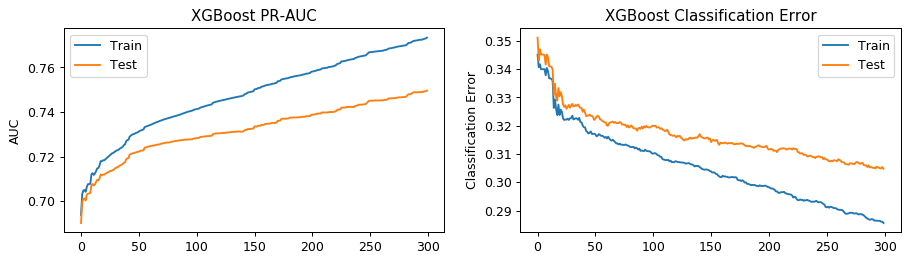

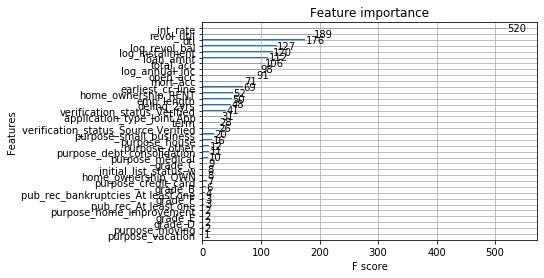

In [64]:
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)
ax1.plot(x_axis, results['validation_0']['auc'], label='Train')
ax1.plot(x_axis, results['validation_1']['auc'], label='Test')
ax1.legend()
ax1.set_ylabel('AUC')
ax1.set_title('XGBoost PR-AUC')

ax2.plot(x_axis, results['validation_0']['error'], label='Train')
ax2.plot(x_axis, results['validation_1']['error'], label='Test')
ax2.legend()
ax2.set_ylabel('Classification Error')
ax2.set_title('XGBoost Classification Error')
plt.show()

plot_importance(model_xgb)
plt.show()

In [65]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import accuracy_score
# thresholds = np.sort(model_xgb.feature_importances_)
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(model_xgb, threshold=thresh, prefit=True)
#     select_x_train = selection.transform(x_train)
#     # train model
#     selection_model = XGBClassifier(scale_pos_weight=class_weights[1])
#     selection_model.fit(select_x_train, y_train.values.ravel())
#     # eval model
#     select_x_test = selection.transform(x_test)
#     y_pred_xgb = selection_model.predict(select_x_test)
#     predictions = [round(value) for value in y_pred_xgb]
#     accuracy = accuracy_score(y_test, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, 
#                                                   select_x_train.shape[1], 
#                                                   accuracy * 100))

In [66]:
important_indices = ['log_annual_inc',
                     'dti',
                     'home_ownership_OWN',
                     'home_ownership_RENT',
                     'log_installment',
                     'int_rate',
                     'loan_amnt',
                     'revol_util',
                     'grade_B',
                     'grade_C',
                     'grade_D',
                     'grade_E',
                     'grade_F',
                     'grade_G',
                     'term',
                     'verification_status_Source Verified',
                     'verification_status_Verified']
x_train_xgb = x_train.loc[:, important_indices]
x_test_xgb = x_test.loc[:, important_indices]

#### Base Model

In [67]:
model_xgb_base_path = Path('../data/model_xgb_base.joblib')
if os.path.exists(model_xgb_base_path):
    model_xgb_base = load(model_xgb_base_path)
else:
    model_xgb_base = XGBClassifier(max_depth=3, 
                                   learning_rate=0.05, 
                                   n_estimators=300, 
                                   objective='binary:logistic', 
                                   subsample=0.8, 
                                   random_state=42)
    model_xgb_base.fit(x_train_xgb, y_train.values.ravel())
    dump(model_xgb_base, model_xgb_base_path)

#### Cost Sensitive Method

In [68]:
model_path_xgb = Path('../data/model_xgb.joblib')
if os.path.exists(model_path_xgb):
    model_xgb = load(model_path_xgb)
else:
    neg_weight = y_train['loan_status'].value_counts(dropna=False)[0]/y_train['loan_status'].value_counts(dropna=False)[1]
    model_xgb = XGBClassifier(max_depth=3,
                              learning_rate=0.05,
                              n_estimators=300,
                              objective='binary:logistic',
                              subsample=0.8,
                              scale_pos_weight=neg_weight, 
                              random_state=42)
    model_xgb.fit(x_train_xgb, y_train.values.ravel())
    dump(model_xgb, model_path_xgb)

#### Sampling Method - SMOTE

In [69]:
model_xgb_smote_path = Path('../data/model_xgb_smote.joblib')
if os.path.exists(model_xgb_smote_path):
    model_xgb_smote = load(model_xgb_smote_path)
else:
    x_train_xgb_sm, y_train_sm = SMOTE(random_state=1).fit_resample(x_train_xgb, y_train.values.ravel())
    x_train_xgb_sm = pd.DataFrame(x_train_xgb_sm, columns=x_test_xgb.columns)
    y_train_sm = pd.DataFrame(y_train_sm, columns=y_train.columns)
    model_xgb_smote = XGBClassifier(max_depth=3, 
                                    learning_rate=0.01, 
                                    n_estimators=300, 
                                    objective='binary:logistic', 
                                    subsample=0.8, 
                                    random_state=42)
    model_xgb_smote.fit(x_train_xgb_sm, y_train_sm.values.ravel())
    dump(model_xgb_smote, model_xgb_smote_path)

#### Sampling Method - ADASYN

In [70]:
model_xgb_adasyn_path = Path('../data/model_xgb_adasyn.joblib')
if os.path.exists(model_xgb_adasyn_path):
    model_xgb_adasyn = load(model_xgb_adasyn_path)
else:
    x_train_xgb_as, y_train_as = ADASYN(random_state=1).fit_sample(x_train_xgb, y_train.values.ravel())
    x_train_xgb_as = pd.DataFrame(x_train_xgb_as, columns=x_test_xgb.columns)
    y_train_as = pd.DataFrame(y_train_as, columns=y_train.columns)
    model_xgb_adasyn = XGBClassifier(max_depth=3, 
                                     learning_rate=0.01, 
                                     n_estimators=300, 
                                     objective='binary:logistic', 
                                     subsample=0.8, 
                                     random_state=42)
    model_xgb_adasyn.fit(x_train_xgb_as, y_train_as.values.ravel())
    dump(model_xgb_adasyn, model_xgb_adasyn_path)

### XGBoost Results

In [71]:
# Make predictions and determine the error
y_pred_xgb = model_xgb_base.predict(x_test_xgb)
print("Accuracy: %.2f%%" % (model_xgb_base.score(x_test_xgb, y_test) * 100))
print(confusion_matrix(y_test, y_pred_xgb))
print('F1 Score:', f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
# predict probabilities
prob = model_xgb_base.predict_proba(x_test_xgb)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_xgb, recall_xgb, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_xgb, precision_xgb))

Accuracy: 69.51%
[[6757 1472]
 [2568 2454]]
F1 Score: 0.5485024586499776
              precision    recall  f1-score   support

           0       0.72      0.82      0.77      8229
           1       0.63      0.49      0.55      5022

    accuracy                           0.70     13251
   macro avg       0.67      0.65      0.66     13251
weighted avg       0.69      0.70      0.69     13251

PR-AUC:  0.6219669164829286


#### Cost Sensitive Method

In [72]:
# Make predictions and determine the error
y_pred_xgb = model_xgb.predict(x_test_xgb)
print("Accuracy: %.2f%%" % (model_xgb.score(x_test_xgb, y_test) * 100))
print(confusion_matrix(y_test, y_pred_xgb))
print('F1 Score:', f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
# predict probabilities
prob = model_xgb.predict_proba(x_test_xgb)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_xgb, recall_xgb, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_xgb, precision_xgb))

Accuracy: 67.63%
[[5281 2948]
 [1342 3680]]
F1 Score: 0.6317596566523604
              precision    recall  f1-score   support

           0       0.80      0.64      0.71      8229
           1       0.56      0.73      0.63      5022

    accuracy                           0.68     13251
   macro avg       0.68      0.69      0.67     13251
weighted avg       0.71      0.68      0.68     13251

PR-AUC:  0.621457929718918


#### Sampling Method - SMOTE

In [73]:
y_pred_xgb = model_xgb_smote.predict(x_test_xgb)
print("Accuracy: %.2f%%" % (model_xgb_smote.score(x_test_xgb, y_test) * 100))
print(confusion_matrix(y_test, y_pred_xgb))
print('F1 Score:', f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
# predict probabilities
prob = model_xgb_smote.predict_proba(x_test_xgb)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_xgb, recall_xgb, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_xgb, precision_xgb))

Accuracy: 66.77%
[[6013 2216]
 [2187 2835]]
F1 Score: 0.5628908964558722
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8229
           1       0.56      0.56      0.56      5022

    accuracy                           0.67     13251
   macro avg       0.65      0.65      0.65     13251
weighted avg       0.67      0.67      0.67     13251

PR-AUC:  0.5839595093688296


#### Sampling Method - ADASYN

In [74]:
y_pred_xgb = model_xgb_adasyn.predict(x_test_xgb)
print("Accuracy: %.2f%%" % (model_xgb_adasyn.score(x_test_xgb, y_test) * 100))
print(confusion_matrix(y_test, y_pred_xgb))
print('F1 Score:', f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
# predict probabilities
prob = model_xgb_adasyn.predict_proba(x_test_xgb)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_xgb, recall_xgb, threshold = precision_recall_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_xgb, precision_xgb))

Accuracy: 66.83%
[[6014 2215]
 [2180 2842]]
F1 Score: 0.5639448357972022
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8229
           1       0.56      0.57      0.56      5022

    accuracy                           0.67     13251
   macro avg       0.65      0.65      0.65     13251
weighted avg       0.67      0.67      0.67     13251

PR-AUC:  0.584599657530125


### Ensemble Model

In [75]:
# Random Forest Model
output_rf = model_rf.predict_proba(x_test_rf)
output_rf2 = model_rf.predict(x_test_rf)

# Neural Network Model
output_nn = model_nn_adasyn.predict(x_test_nn)
output_nn2 = model_nn_adasyn.predict_classes(x_test_nn)

# XGBoost Model
output_xgb = model_xgb.predict_proba(x_test_xgb)
output_xgb2 = model_xgb.predict(x_test_xgb)

# Ensemble output
# Avg
output = (output_rf + output_nn + output_xgb) / 3

# Majority vote
output2 = pd.DataFrame({'rf': output_rf2, 'nn': output_nn2, 'xgb': output_xgb2})
output2['Prediction'] = output2.sum(axis=1)
output2.loc[output2['Prediction'] < 2, 'Prediction'] = 0
output2.loc[output2['Prediction'] >= 2, 'Prediction'] = 1

#### Stacking

In [76]:
# Obtain the base first-level model predictions
y_pred_stacking_rf = model_rf.predict(x_train_rf)
y_pred_stacking_nn = model_nn_adasyn.predict_classes(x_train_nn)
y_pred_stacking_xgb = model_xgb.predict(x_train_xgb)
x_train_stacking = pd.DataFrame({'rf': y_pred_stacking_rf, 'nn': y_pred_stacking_nn, 'xgb': y_pred_stacking_xgb})
y_train_stacking = pd.DataFrame(y_train.copy())
x_test_stacking = pd.DataFrame({'rf': output_rf2, 'nn': output_nn2, 'xgb': output_xgb2})
y_test_stacking = pd.DataFrame(y_test.copy())

# Fit the Meta Learner from first level predictions
neg_weight = y_train_stacking['loan_status'].value_counts(dropna=False)[0] / y_train_stacking['loan_status'].value_counts(dropna=False)[1]
model_stacking_xgb = XGBClassifier(max_depth=3, 
                                   learning_rate=0.05, 
                                   n_estimators=300, 
                                   objective='binary:logistic', 
                                   subsample=0.8, 
                                   scale_pos_weight=neg_weight, 
                                   random_state=42)
model_stacking_xgb.fit(x_train_stacking, y_train_stacking.values.ravel())

model_stacking_lr = LogisticRegression(penalty="l2", C=0.5, fit_intercept=True, class_weight='balanced',
                                       random_state=0, max_iter=10000, solver='lbfgs')
model_stacking_lr.fit(x_train_stacking, y_train_stacking.values.ravel())

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

### Ensemble Results

In [77]:
p_output = pd.DataFrame(output.copy())
p_output.columns = ['Fully Paid', 'Default']
p_output['Prediction'] = p_output.idxmax(axis=1)
p_output['Fully Paid'] = p_output['Fully Paid'].multiply(100).round(0).astype(int).astype(str) + '%'
p_output['Default'] = p_output['Default'].multiply(100).round(0).astype(int).astype(str) + '%'

y_test2 = pd.DataFrame(y_test.copy())
y_test2.columns = ['Prediction']
y_test2['Prediction'].replace(0, 'Fully Paid', inplace=True)
y_test2['Prediction'].replace(1, 'Default', inplace=True)
print('Averaging Method')
accuracy = accuracy_score(y_true=y_test2, y_pred=p_output['Prediction'])
print("Accuracy: %.2f%%" % (accuracy * 100))
print(confusion_matrix(y_test2, p_output['Prediction']))
print(classification_report(y_test2, p_output['Prediction']))

# Majority
output2['Prediction'].replace(0, 'Fully Paid', inplace=True)
output2['Prediction'].replace(1, 'Default', inplace=True)

print('\nMajority Method')
accuracy = accuracy_score(y_true=y_test2, y_pred=output2['Prediction'])
print("Accuracy: %.2f%%" % (accuracy * 100))
print(confusion_matrix(y_test2, output2['Prediction']))
print(classification_report(y_test2, output2['Prediction']))

Averaging Method
Accuracy: 66.70%
[[3572 1450]
 [2963 5266]]
              precision    recall  f1-score   support

     Default       0.55      0.71      0.62      5022
  Fully Paid       0.78      0.64      0.70      8229

    accuracy                           0.67     13251
   macro avg       0.67      0.68      0.66     13251
weighted avg       0.69      0.67      0.67     13251


Majority Method
Accuracy: 66.65%
[[3599 1423]
 [2996 5233]]
              precision    recall  f1-score   support

     Default       0.55      0.72      0.62      5022
  Fully Paid       0.79      0.64      0.70      8229

    accuracy                           0.67     13251
   macro avg       0.67      0.68      0.66     13251
weighted avg       0.70      0.67      0.67     13251



In [78]:
# Predict the test
y_pred_xgb = model_stacking_xgb.predict(x_test_stacking)
print("Accuracy: %.2f%%" % (model_stacking_xgb.score(x_test_stacking, y_test_stacking) * 100))
print(confusion_matrix(y_test_stacking, y_pred_xgb))
print('F1 Score:', f1_score(y_test_stacking, y_pred_xgb))
print(classification_report(y_test_stacking, y_pred_xgb))
# predict probabilities
prob = model_stacking_xgb.predict_proba(x_test_stacking)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_xgb, recall_xgb, threshold = precision_recall_curve(y_test_stacking, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_xgb, precision_xgb))

Accuracy: 65.67%
[[5234 2995]
 [1554 3468]]
F1 Score: 0.6039181541140619
              precision    recall  f1-score   support

           0       0.77      0.64      0.70      8229
           1       0.54      0.69      0.60      5022

    accuracy                           0.66     13251
   macro avg       0.65      0.66      0.65     13251
weighted avg       0.68      0.66      0.66     13251

PR-AUC:  0.669572334466345


In [79]:
y_pred_lr = model_stacking_lr.predict(x_test_stacking)
print("Accuracy: %.2f%%" % (model_stacking_lr.score(x_test_stacking, y_test_stacking) * 100))
print(confusion_matrix(y_test_stacking, y_pred_lr))
print('F1 Score:', f1_score(y_test_stacking, y_pred_lr))
print(classification_report(y_test_stacking, y_pred_lr))
# predict probabilities
prob = model_stacking_lr.predict_proba(x_test_stacking)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_lr, recall_lr, threshold = precision_recall_curve(y_test_stacking, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_lr, precision_lr))

Accuracy: 66.47%
[[5386 2843]
 [1600 3422]]
F1 Score: 0.6063613006113228
              precision    recall  f1-score   support

           0       0.77      0.65      0.71      8229
           1       0.55      0.68      0.61      5022

    accuracy                           0.66     13251
   macro avg       0.66      0.67      0.66     13251
weighted avg       0.69      0.66      0.67     13251

PR-AUC:  0.6705189734401573


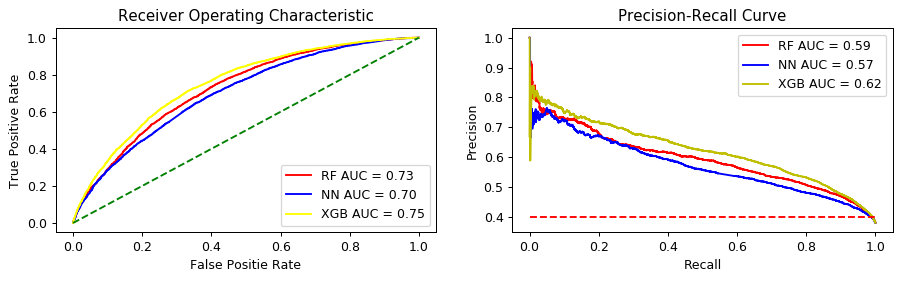

In [80]:
# predict probabilities
model_rf = load(model_rf_path)
model_nn = load_model(str(Path('../data/model_nn_adasyn.h5')))
model_xgb = load(model_path_xgb)
pos_pred_rf = model_rf.predict_proba(x_test_rf)
pos_pred_nn = model_nn.predict(x_test_nn)
pos_pred_xgb = model_xgb.predict_proba(x_test_xgb)
# keep probabilities for the positive outcome only
pos_pred_rf = pos_pred_rf[:,1]
pos_pred_nn = pos_pred_nn[:,1]
pos_pred_xgb = pos_pred_xgb[:,1]
# calculate roc curve
fpr_rf, tpr_rf, threshold = roc_curve(y_test, pos_pred_rf)
fpr_nn, tpr_nn, threshold = roc_curve(y_test, pos_pred_nn)
fpr_xgb, tpr_xgb, threshold = roc_curve(y_test, pos_pred_xgb)
# # calculate auc, equivalent to roc_auc_score()?
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_nn = auc(fpr_nn, tpr_nn)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)
ax1.set_title('Receiver Operating Characteristic')
ax1.plot(fpr_rf, tpr_rf, 'r', label = 'RF AUC = %0.2f' % roc_auc_rf)
ax1.plot(fpr_nn, tpr_nn, 'b', label = 'NN AUC = %0.2f' % roc_auc_nn)
ax1.plot(fpr_xgb, tpr_xgb, color='yellow', label = 'XGB AUC = %0.2f' % roc_auc_xgb)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1], 'g--')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positie Rate')

precision_rf, recall_rf, threshold = precision_recall_curve(y_test, pos_pred_rf)
precision_nn, recall_nn, threshold = precision_recall_curve(y_test, pos_pred_nn)
precision_xgb, recall_xgb, threshold = precision_recall_curve(y_test, pos_pred_xgb)
pr_auc_rf = auc(recall_rf, precision_rf)
pr_auc_nn = auc(recall_nn, precision_nn)
pr_auc_xgb = auc(recall_xgb, precision_xgb)
ax2.set_title('Precision-Recall Curve')
ax2.plot(recall_rf, precision_rf, 'r', label = 'RF AUC = %0.2f' % pr_auc_rf)
ax2.plot(recall_nn, precision_nn, 'b', label = 'NN AUC = %0.2f' % pr_auc_nn)
ax2.plot(recall_xgb, precision_xgb, 'y', label = 'XGB AUC = %0.2f' % pr_auc_xgb)
ax2.legend(loc = 'upper right')
ax2.plot([0, 1], [0.4, 0.4], 'r--')
ax2.set_ylabel('Precision')
ax2.set_xlabel('Recall')
plt.show()

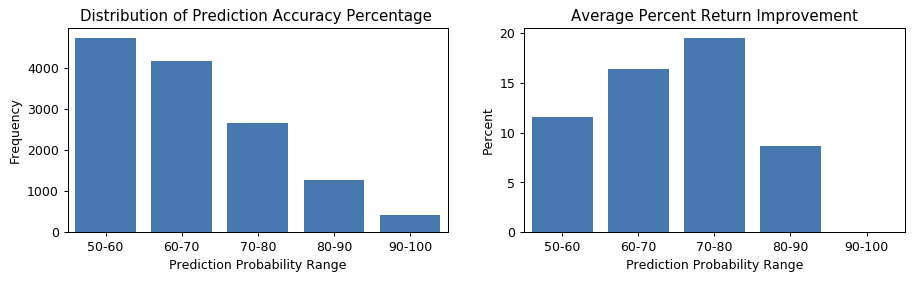

In [81]:
accu_metrics = pd.DataFrame(p_output.copy())
accu_metrics['Actual'] = y_test2.to_numpy()
accu_metrics['category'] = accu_metrics[['Fully Paid', 'Default']].max(axis=1)
accu_metrics['category'] = accu_metrics['category'].str.rstrip('%').astype('float')
temp = pd.DataFrame(x_test['loan_amnt'])
temp = temp.join(test_pymnts)
temp.reset_index(inplace=True, drop=True)
accu_metrics = accu_metrics.join(temp)
accu_metrics['PL'] = ((accu_metrics['total_pymnt'] - accu_metrics['loan_amnt']) / abs(accu_metrics['loan_amnt'])) * 100
accu_metrics['proba_range'] = pd.cut(accu_metrics['category'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=False,
                           labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', 
                                   '60-70', '70-80', '80-90', '90-100'], include_lowest=True)
accu_metrics['correct'] = 0
accu_metrics.loc[accu_metrics['Prediction'] == accu_metrics['Actual'], 'correct'] = 1
accu_metric = pd.DataFrame(accu_metrics.groupby('proba_range')['correct'].sum())
accu_metric['total'] = accu_metrics.groupby(['proba_range']).count()['correct']
accu_metric['Accuracy'] = accu_metric['correct'] / accu_metric['total'] * 100
accu_metric.dropna(inplace=True)
accu_metric.reset_index(inplace=True)

returns_orgi = pd.DataFrame(accu_metrics.groupby('proba_range')['PL'].sum())
returns_orgi['rows'] = accu_metrics.groupby(['proba_range']).count()['correct']
returns_orgi['Avg_pct_return'] = returns_orgi['PL'] / returns_orgi['rows']
returns_new = accu_metrics.loc[accu_metrics['Prediction']=='Fully Paid']
returns_new = pd.DataFrame(returns_new.groupby('proba_range')['PL'].sum())
returns_new['rows'] = accu_metrics.groupby(['proba_range']).count()['correct']
returns_new['Avg_pct_return'] = returns_new['PL'] / returns_new['rows']
returns_chart = pd.DataFrame()
returns_chart['avg_improvement'] = returns_new['Avg_pct_return'] - returns_orgi['Avg_pct_return']
returns_chart.dropna(inplace=True)
returns_chart.reset_index(inplace=True)

# This is for get rid of the groupby no data issue
accu_metric.to_csv('../data/fuck.csv', index=False)
accu_metric = pd.read_csv(Path('../data/fuck.csv'), header=0)
returns_chart.to_csv('../data/fuck2.csv')
returns_chart = pd.read_csv(Path('../data/fuck2.csv'), header=0)

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)
sns.barplot(x='proba_range', y='total', data=accu_metric, color=sns.xkcd_rgb['windows blue'], ax=ax1)
ax1.set_xlabel('Prediction Probability Range')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Prediction Accuracy Percentage ')
# ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
sns.barplot(x='proba_range', y="avg_improvement", data=returns_chart, color=sns.xkcd_rgb['windows blue'], ax=ax2)
ax2.set_xlabel('Prediction Probability Range')
ax2.set_ylabel('Percent')
ax2.set_title('Average Percent Return Improvement')
# ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.show()

In [82]:
print('Overall return without model:', ((accu_metrics['total_pymnt'].sum()/accu_metrics['loan_amnt'].sum()) - 1) * 100)

total_cost = accu_metrics.loc[accu_metrics['Prediction'] == 'Fully Paid']['loan_amnt'].sum()
total_return = accu_metrics.loc[accu_metrics['Prediction'] == 'Fully Paid']['total_pymnt'].sum()
print('Overall return with model:', ((total_return/total_cost) - 1) * 100)

orig_roi = accu_metrics['total_pymnt'].sum() - accu_metrics['loan_amnt'].sum()
new_roi = total_return - total_cost
pcnt_chng = ((new_roi - orig_roi) / abs(orig_roi)) * 100
print('Percent improvement:', pcnt_chng)

Overall return without model: -20.615711683298986
Overall return with model: -8.078301566512902
Percent improvement: 83.41007713613459
